In [82]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import random
from glob import glob
from PIL import Image

import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
#import autokeras as ak

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [104]:
# seed must be equal for both training and validation not to overlap.
BATCH_SIZE = 32
#Keep the aspect ratio improves the learning rate and accuracy
IMG_SIZE = (200, 150)  # resolution
directory = "Data/Dataset-ThreeClasses/"

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             label_mode='categorical',
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             color_mode='rgb',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             color_mode='rgb',
                                             seed=42)

Found 8917 files belonging to 3 classes.
Using 7134 files for training.
Found 8917 files belonging to 3 classes.
Using 1783 files for validation.


In [105]:
nv = 6705
mel = 1113
bkl = 1099

In [106]:
total = nv + mel + bkl 

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / bkl) * (total / 3.0) -1
weight_for_1 = (1 / mel) * (total / 3.0) -1
weight_for_2 = (1 / nv) * (total / 3.0)  +0.3

In [107]:
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 1: {:.2f}'.format(weight_for_0))
print('Weight for class 2: {:.2f}'.format(weight_for_1))
print('Weight for class 3: {:.2f}'.format(weight_for_2))

Weight for class 1: 1.70
Weight for class 2: 1.67
Weight for class 3: 0.74


In [108]:
class_names = train_dataset.class_names
class_names

['bkl', 'mel', 'nv']

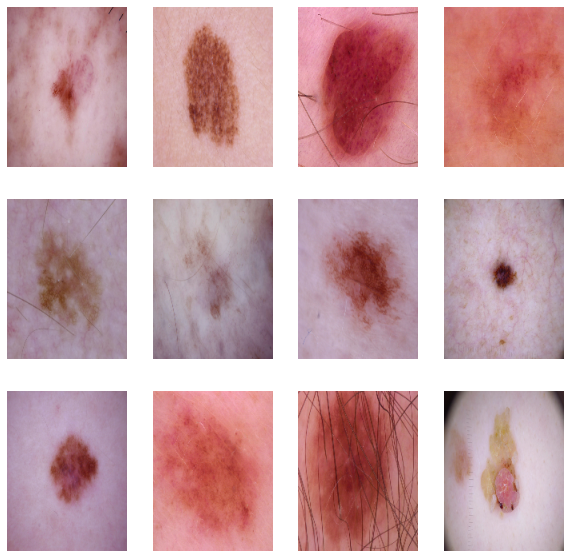

In [109]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")

In [110]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# prevents a memory bottleneck that can occur when reading from disk

In [111]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

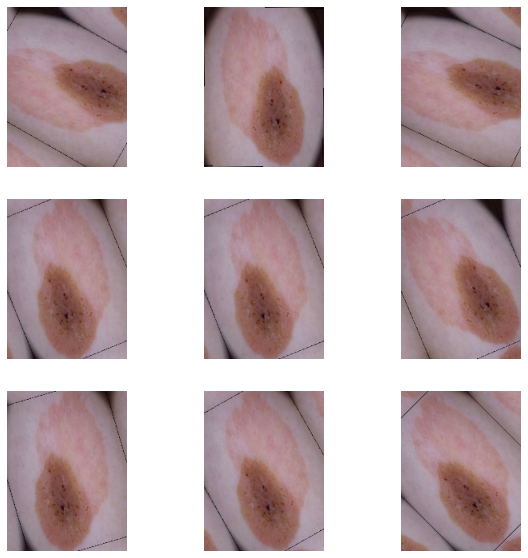

In [112]:
#preview first image augmentations
data_augmentation = data_augmenter()
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0]/ 255)  # 0-1 float or 0-255 integer values
        plt.axis('off')

In [113]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input #data preprocessing using the same weights the model was trained on

In [114]:
# MobileNet V2 trained on imagenet data
IMG_SHAPE = IMG_SIZE + (3,) # as Img size 160*160 only but we need it 160*160*3 for the model
base_model = tf.keras.applications.ResNet101V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 200, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 156, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 75, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 102, 77, 64)  0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [115]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name)  # Last Layer name
# Last two layers are called top layers (Classification)

post_bn
post_relu


In [116]:
# Create the breast cancer model
def BC_model(image_shape=IMG_SIZE):
    ''' Define a tf.keras model for multi-class classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.ResNet101V2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # Create the model with its weights without the top layers
     
    base_model.trainable = False  # not to train any of the base model and train only the new layers will be added
    inputs = tf.keras.Input(shape=input_shape)
    
    x = data_augmentation(inputs) # augmenting the input
    
    x = preprocess_input(inputs) #data preprocessing using the same weights the model was trained on
    
    x = base_model(x, training=False)
    
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.25)(x)
    prediction_layer = tfl.Dense(3, activation='softmax') 
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    return model

In [117]:
BCModel = BC_model(IMG_SIZE)

In [118]:
base_learning_rate = 0.01
BCModel.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'TruePositives'])

In [119]:
initial_epochs = 5
#Add class weigths 
history = BCModel.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs,
                      use_multiprocessing= True, class_weight= class_weight,
                      callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2))

Epoch 1/5
223/223 [==============================] - 688s 3s/step - loss: 1.3256 - accuracy: 0.7079 - true_positives: 4978.0000 - val_loss: 1.1996 - val_accuracy: 0.6534 - val_true_positives: 1140.0000
Epoch 2/5
223/223 [==============================] - 688s 3s/step - loss: 1.2961 - accuracy: 0.7433 - true_positives: 5258.0000 - val_loss: 0.9881 - val_accuracy: 0.7330 - val_true_positives: 1301.0000
Epoch 3/5
223/223 [==============================] - 689s 3s/step - loss: 1.2851 - accuracy: 0.7463 - true_positives: 5281.0000 - val_loss: 1.2847 - val_accuracy: 0.7734 - val_true_positives: 1376.0000
Epoch 4/5
223/223 [==============================] - 696s 3s/step - loss: 1.1991 - accuracy: 0.7632 - true_positives: 5415.0000 - val_loss: 0.9564 - val_accuracy: 0.7801 - val_true_positives: 1372.0000
Epoch 5/5
223/223 [==============================] - 699s 3s/step - loss: 1.2714 - accuracy: 0.7630 - true_positives: 5419.0000 - val_loss: 1.4684 - val_accuracy: 0.6865 - val_true_positives: 

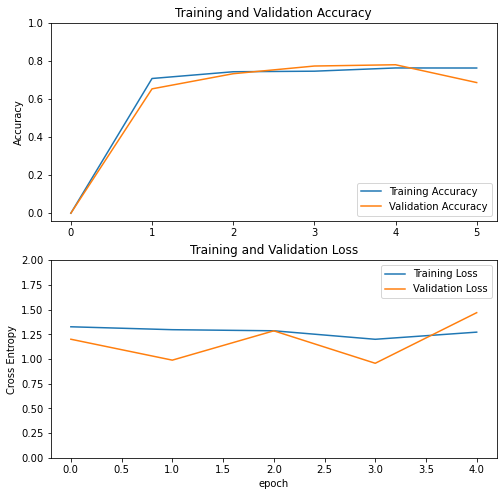

In [120]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [121]:
# Make it trainable from specified layer number
base_model.trainable = True # Make all trainable as a start
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  377


In [122]:
fine_tune_at = 250 # Number to choose

for layer in base_model.layers[:fine_tune_at]:
    #print('Layer ' + layer.name + ' frozen.')
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= 'categorical_crossentropy'
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)# 0.001
# Use accuracy as evaluation metric
metrics=['accuracy', 'TruePositives']

### END CODE HERE

BCModel.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [123]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = BCModel.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], 
                           validation_data=validation_dataset, class_weight= class_weight,
                           callbacks=tf.keras.callbacks.EarlyStopping(patience=2))

Epoch 5/10
223/223 [==============================] - 702s 3s/step - loss: 0.8926 - accuracy: 0.8029 - true_positives: 5699.0000 - val_loss: 0.7926 - val_accuracy: 0.7858 - val_true_positives: 1390.0000
Epoch 6/10
223/223 [==============================] - 688s 3s/step - loss: 0.7675 - accuracy: 0.8053 - true_positives: 5713.0000 - val_loss: 0.7783 - val_accuracy: 0.7830 - val_true_positives: 1371.0000
Epoch 7/10
223/223 [==============================] - 690s 3s/step - loss: 0.6799 - accuracy: 0.8183 - true_positives: 5795.0000 - val_loss: 0.7116 - val_accuracy: 0.7998 - val_true_positives: 1409.0000
Epoch 8/10
223/223 [==============================] - 694s 3s/step - loss: 0.6792 - accuracy: 0.8133 - true_positives: 5757.0000 - val_loss: 0.7537 - val_accuracy: 0.7706 - val_true_positives: 1357.0000
Epoch 9/10
223/223 [==============================] - 706s 3s/step - loss: 0.6488 - accuracy: 0.8252 - true_positives: 5831.0000 - val_loss: 0.7179 - val_accuracy: 0.7824 - val_true_positi

In [124]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

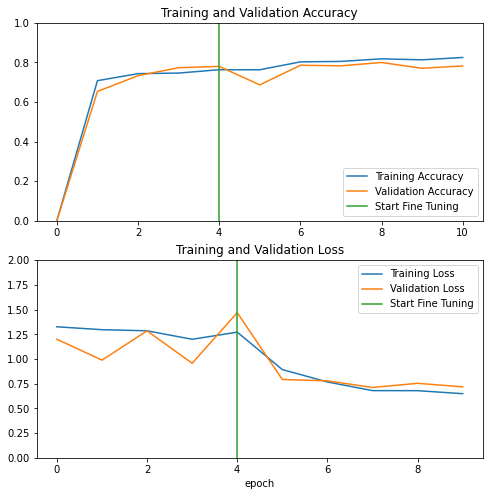

In [125]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.summary()

In [126]:
BCModel.evaluate(validation_dataset)

56/56 [==============================] - 134s 2s/step - loss: 0.7179 - accuracy: 0.7824 - true_positives: 1380.0000


[0.7178686261177063, 0.782389223575592, 1380.0]

In [127]:
BCModel.evaluate(train_dataset)

223/223 [==============================] - 516s 2s/step - loss: 0.3291 - accuracy: 0.8717 - true_positives: 6146.0000


[0.32910022139549255, 0.8717409372329712, 6146.0]

In [128]:
folder_dir = 'Data/Test/mel/'
predicts = []
for img in os.listdir(folder_dir):
    img_width, img_height = 200, 150
    img = tf.keras.preprocessing.image.load_img(os.path.join(folder_dir,img), target_size = (img_width, img_height))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    array_probs = BCModel.predict(img)
    predicts.append(class_names[np.where(array_probs == np.amax(array_probs))[1][0]])


In [197]:
#for img,labels in train_dataset:
    #plt.imshow(imgs.numpy().astype("uint8"))
    #detect = list(labels[11].numpy())
    #print(class_names[detect.index(max(detect))])
 #  img = np.expand_dims(img, axis = 0)
    #print(img)
    #list_probs = list(BCModel.predict(img))
    #print(class_names[list_probs.index(max(list_probs))])

In [130]:
predicts.count('mel')

159

In [36]:
BCModel.save('ThreeClassesModel')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ThreeClassesModel\assets


In [33]:
BCModel.save('ThreeClassesModelAR')

INFO:tensorflow:Assets written to: ThreeClassesModelAR\assets


In [65]:
pth = 'Data/Test/mel/ISIC_0026352.jpg'
img_width, img_height = 200, 150
img = tf.keras.preprocessing.image.load_img(pth, target_size = (img_width, img_height))
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis = 0)
array_probs = BCModel.predict(img)
print(class_names[np.where(array_probs == np.amax(array_probs))[1][0]])

mel


In [66]:
array_probs

array([[1.9597721e-06, 8.6070728e-01, 1.3929076e-01]], dtype=float32)

In [131]:
BCModel.save('ThreeClassesModelClassWeighting')

INFO:tensorflow:Assets written to: ThreeClassesModelClassWeighting\assets
